<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/Notebooks/OC_ConvAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> One-Class Classification Using Convolutional Autoencoders </h1>

The main idea is to train a CAE (Convolutional Autoencoder) with data from the positive class only and calculate a reconstruction error threshold T based on the reconstruction errors obtained during the training. <br/>
Then we perform the One-Class Classification (OCC) as follows:

- For each data sample in the test dataset, do:
    - Reconstruct the data with the CAE and calculate its reconstruction error E.
    - if E <= T the sample is classified as a member of the positive class.
    - else (if E > T) the sample is classified as not a member of the positive class.  

- Evaluate the Model's Accuracy, Precision and Recall.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Convolutional Autoencoders

## Using MaxPooling
- Subclassing

In [ ]:
# Convolutional Autoencoder with MaxPooling:
class ConvAutoencoder(tf.keras.Model):
    def __init__(self, serie_length):
        super(ConvAutoencoder, self).__init__()
        self.conv_1 = keras.layers.Conv1D(128, 3, activation='swish', padding='same', input_shape=(serie_length))
        self.max_1 = keras.layers.MaxPooling1D(2, padding='same')
        self.conv_2 = keras.layers.Conv1D(64, 3, activation='swish', padding='same')
        self.max_2 = keras.layers.MaxPooling1D(2, padding='same')
        self.conv_3 = keras.layers.Conv1D(1, 3, activation='swish', padding='same')
    
        # encoded representation
        self.encoded = keras.layers.MaxPooling1D(2, padding='same')
        
        # decoder layers
        self.conv_4 = keras.layers.Conv1D(1, 3, activation='swish', padding='same')
        self.up_1 = keras.layers.UpSampling1D(2)
        self.conv_5 = keras.layers.Conv1D(64, 3, activation='swish', padding='same')
        self.up_2 = keras.layers.UpSampling1D(2)
        self.conv_6 = keras.layers.Conv1D(128, 3, activation='swish', padding='same')
        self.up_3 = keras.layers.UpSampling1D(2)
        self.decoded = keras.layers.Conv1D(1, 3, activation='linear', padding='same')
        
    def call(self, inputs):
        print(inputs.shape)
        x = self.conv_1(inputs)
        x = self.max_1(x)
        x = self.conv_2(x)
        x = self.max_2(x)
        x = self.conv_3(x)
        x = self.encoded(x)
        x = self.conv_4(x)
        x = self.up_1(x)
        x = self.conv_5(x)
        x = self.up_2(x)
        x = self.conv_6(x)
        x = self.up_3(x)
        return self.decoded(x)
        #x = self.conv_7(x)
        #self.cropping = x.shape[1] - inputs.shape[1] 
        #return keras.layers.Cropping1D(cropping=(0,self.cropping))(x)
    
    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

## Using Strides = 2

In [ ]:
# Convolutional Autoencoder with Strides:
class ConvAutoencoderStrides():
  def __init__(self, serie_length):
    # encoder layers
    input_data = Input(shape=(serie_length, 1))
    x = Conv1D(128, (3), strides=2, activation='swish', padding='same')(input_data)
    x = Conv1D(64, (3), strides=2, activation='swish', padding='same')(x)
    x = Conv1D(32, (3), strides=2, activation='swish', padding='same')(x)
    
    # encoded representation
    encoded = Conv1D(1, (3), activation='swish', padding='same')(x)
    
    # decoder layers
    x = Conv1D(1, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(encoded)
    x = Conv1D(64, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(128, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(1, (3), activation='tanh', padding='same')(x)
    
    # cropping data so that decoded representation has the same shape as the input
    cropping = x.shape[1] - input_data.shape[1] 
    # decoded representation
    decoded = Cropping1D(cropping=(0,cropping))(x)
    
    # models
    self.encoder = Model(input_data, encoded)
    self.autoencoder = Model(input_data, decoded)
    self.autoencoder.compile(optimizer='adam', loss='mse')
    # summary
    self.autoencoder.summary()
    
  def train(self, data, epochs, batch_size):
    #self.callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    history = self.autoencoder.fit(data, data, epochs= epochs, batch_size= batch_size, validation_split=0.1) #, callbacks = [callback])
    
    return self.autoencoder

# Reading Dataset from Google Drive

In [ ]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", delimiter="\t",)

print("Labels:", np.unique(tr_data[:, 0]))

class_label = 1
tr_data = tr_data[tr_data[:,0] == class_label, 1:] # train
tc_data = te_data[te_data[:,0] == class_label, 1:] # target class - test
oc_data = te_data[te_data[:,0] != class_label, 1:] # other classes - test

print("Train data shape: ", tr_data.shape)
print("Test data shape (target class): ", tc_data.shape)
print("Test data shape (other class(es)): ", oc_data.shape)

Dataset: StarLightCurves
Labels: [1. 2. 3.]
Train data shape:  (152, 1024)
Test data shape (target class):  (1177, 1024)
Test data shape (other class(es)):  (7059, 1024)


# Initializing and training the Conv Autoencoder

In [ ]:
# Initialize the Autoencoder
serie_length = tr_data.shape[1]
#input_data = keras.layers.Input(shape=(serie_length, 1))

model = ConvAutoencoder((serie_length, 1))

(1024, 1)


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
tr_data.shape = tr_data.shape[0], tr_data.shape[1], 1
tc_data.shape = tc_data.shape[0], tc_data.shape[1], 1
oc_data.shape = oc_data.shape[0], oc_data.shape[1], 1

In [ ]:
# Train
batch_size = 32
epochs = 50


model.fit(tr_data, tr_data, epochs=epochs, batch_size=batch_size)
autoencoder = model

Epoch 1/50
(None, 1024, 1)
(None, 1024, 1)
5/5 [==============================] - 4s 23ms/step - loss: 0.9977
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.9781
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.9103
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 0.7821
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 0.6271
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4782
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4090
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3548
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3476
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3407
Epoch 11/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3298
Epoch 12/50
5/5 [==============================] - 0s 19ms/step - loss: 0.3215
Epoch 13/50
5/5 [============

In [ ]:
model.model().summary()

# Predicting and Reshaping Data

In [ ]:
# Predicting
tc_data_reconstructed = autoencoder.predict(tc_data)
oc_data_reconstructed = autoencoder.predict(oc_data)
tr_data_reconstructed = autoencoder.predict(tr_data)
# Reshaping
tc_data_reconstructed.shape = tc_data_reconstructed.shape[0], tc_data_reconstructed.shape[1]
oc_data_reconstructed.shape = oc_data_reconstructed.shape[0], oc_data_reconstructed.shape[1]
tr_data_reconstructed.shape = tr_data_reconstructed.shape[0], tr_data_reconstructed.shape[1]


print("Target Class test shape:", tc_data_reconstructed.shape, tc_data.shape)
print("Other Class(es) test shape:", oc_data_reconstructed.shape, oc_data.shape)

Tensor("IteratorGetNext:0", shape=(None, 1024, 1), dtype=float32)
Target Class test shape: (1177, 1024) (1177, 1024, 1)
Other Class(es) test shape: (7059, 1024) (7059, 1024, 1)


# Reconstruction Examples

## Positive Class

MSE: 0.2874314311506479


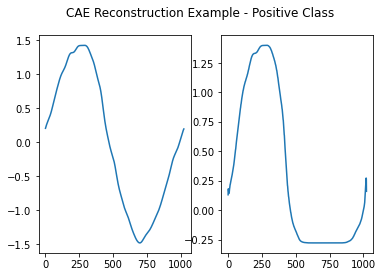

In [ ]:
index = 22
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('CAE Reconstruction Example - Positive Class')
ax1.plot(tc_data[index])
ax2.plot(tc_data_reconstructed[index])
print("MSE:", mean_squared_error(tc_data[index], tc_data_reconstructed[index]))
#fig.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/ex_{index}_{dataset}_pc.png') # Positive Class

## Negative Class

MSE: 0.2258553116745296


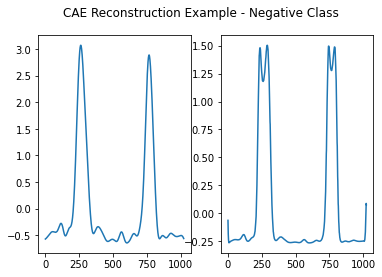

In [ ]:
index = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('CAE Reconstruction Example - Negative Class')
ax1.plot(oc_data[index])
ax2.plot(oc_data_reconstructed[index])
print("MSE:", mean_squared_error(oc_data[index], oc_data_reconstructed[index]))
fig.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/ex_{index}_{dataset}_nc.png') # Negative Class

# Reconstruction Error Histogram

In [ ]:
def err_hist_occ(original_data, encoded_data):
  mse = []
  for i in range(original_data.shape[0]):
    mse.append(mean_squared_error(original_data[i], encoded_data[i]))

  mse = np.array(mse)
  mean = np.mean(mse)
  dp = np.std(mse)
  print("Média:", mean)
  print("Desvio padrão:", dp)

  return mse

## Train Data

Média: 0.30874310553167916
Desvio padrão: 0.03537147814976966


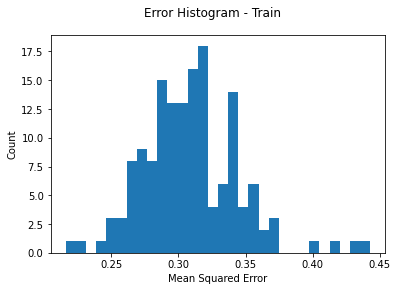

In [ ]:
# Treino
plt.hist(err_hist_occ(tr_data, tr_data_reconstructed), bins = 30)
plt.ylabel('Count')
plt.xlabel('Mean Squared Error');
plt.suptitle('Error Histogram - Train')
plt.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/hist_{dataset}_train.png') # Train

## Test Data - Positive Class

Média: 0.30696137573506105
Desvio padrão: 0.033782306540251494
Accuracy positive class: 0.055225148683092605


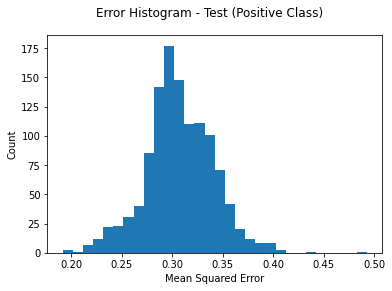

In [ ]:
# Teste só com dado da classe de interesse
mse_pc = err_hist_occ(tc_data, tc_data_reconstructed) 

plt.hist(mse_pc, bins = 30)
plt.ylabel('Count')
plt.xlabel('Mean Squared Error');
plt.suptitle('Error Histogram - Test (Positive Class)')
plt.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/hist_{dataset}_pc.png') # Positive Class

# testing an arbitrary threshold
threshold = 0.25
accuracy = len(mse_pc[mse_pc <= threshold])/len(mse_pc)
print("Accuracy positive class:" , accuracy)

## Test Data - Negative Class

Média: 0.3326672287029857
Desvio padrão: 0.08031155980850538
Accuracy negative class: 0.8717948717948718


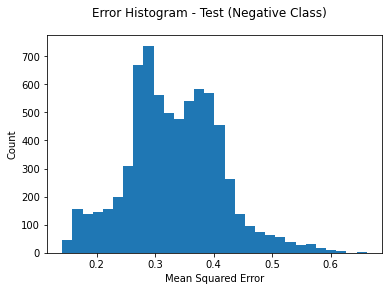

In [ ]:
# Teste com dados da classe negativa
mse_nc = err_hist_occ(oc_data, oc_data_reconstructed)

plt.hist(mse_nc, bins = 30)
plt.ylabel('Count')
plt.xlabel('Mean Squared Error');
plt.suptitle('Error Histogram - Test (Negative Class)')
plt.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/hist_{dataset}_nc.png') # Negative Class

# testing an arbitrary threshold
threshold = 0.25
accuracy = len(mse_nc[mse_nc > threshold])/len(mse_nc)
print("Accuracy negative class:" , accuracy)

# Some tests


In [ ]:
threshold = 0.25

In [ ]:
mse = err_hist_occ(oc_data, oc_data_reconstructed)
false_positive = len(mse[mse<=threshold])
true_negative = len(mse[mse>threshold])
print("False Positive:", false_positive)
print("True Negative:", true_negative)

Média: 0.3326672287029857
Desvio padrão: 0.08031155980850538
False Positive: 905
True Negative: 6154


In [ ]:
mse = err_hist_occ(tc_data, tc_data_reconstructed)
true_positive = len(mse[mse<=threshold])
false_negative = len(mse[mse>threshold])
print("True Positive:", true_positive)
print("False Negative:", false_negative)

Média: 0.30696137573506105
Desvio padrão: 0.033782306540251494
True Positive: 65
False Negative: 1112


In [ ]:
total = false_positive + true_negative + true_positive + false_negative
print("Total:", total)
accuracy = (true_positive + true_negative)/total
precision = true_positive/(true_positive + false_positive)
recall = true_positive/(true_positive + false_negative)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Total: 8236
Accuracy: 0.755099562894609
Precision: 0.06701030927835051
Recall: 0.055225148683092605


# Threshold Definition and OCC Task








In [ ]:
#Placeholder - Algoritmo para def de Threshold e Classificação